### See 06-01-bottleneck notebook first

In [2]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug
import cv2

# Toolbox
from pathlib import Path
from imutils import paths
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Misc
import random
import glob
import shutil
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

# Deep learning
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications import VGG16, MobileNetV2
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input

# Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [3]:
def plot_history(model):
    acc = model.history['acc']
    val_acc = model.history['val_acc']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

In [5]:
base_dir = 'images/split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

nb_train_samples = 2000
nb_test_samples = 1000
nb_validation_samples = 1000
epochs = 5
batch_size = 32
image_size = 150

In [6]:
# Rescale all images by 1./255 and apply image augmentation
train_datagen = ImageDataGenerator(
                rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Create the base model from the pre-trained convnets

In [7]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Feature extraction

We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [8]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Add a classification head

Now let's add a few layers on top of the base model:

In [9]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1, activation='sigmoid')
])

### Compile

In [10]:
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


These 513 trainable parameters are divided among 2 TensorFlow Variable objects, the weights and biases of the two dense layers:


In [12]:
len(model.trainable_weights)

2

### Train the model

In [13]:
epochs=10
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
125/125 [==============================] - 14s 111ms/step - loss: 0.6760 - acc: 0.5665 - val_loss: 0.6640 - val_acc: 0.6386
Epoch 2/10
125/125 [==============================] - 12s 98ms/step - loss: 0.6499 - acc: 0.6685 - val_loss: 0.6412 - val_acc: 0.6956
Epoch 3/10
125/125 [==============================] - 12s 97ms/step - loss: 0.6279 - acc: 0.7202 - val_loss: 0.6205 - val_acc: 0.7368
Epoch 4/10
125/125 [==============================] - 12s 96ms/step - loss: 0.6064 - acc: 0.7532 - val_loss: 0.5986 - val_acc: 0.7713
Epoch 5/10
125/125 [==============================] - 12s 96ms/step - loss: 0.5885 - acc: 0.7820 - val_loss: 0.5833 - val_acc: 0.7881
Epoch 6/10
125/125 [==============================] - 12s 96ms/step - loss: 0.5717 - acc: 0.7940 - val_loss: 0.5666 - val_acc: 0.8018
Epoch 7/10
125/125 [==============================] - 12s 99ms/step - loss: 0.5561 - acc: 0.8043 - val_loss: 0.5522 - val_acc: 0.8034
Epoch 8/10
12

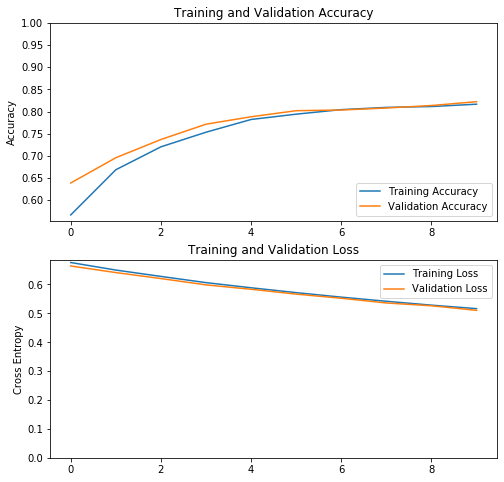

In [14]:
plot_history(history)

### Fine-tuning (Part 2)

In our feature extraction experiment, we were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the top-level classifier. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

#### Note

This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will just forget everything it has learned.

Additionally, the reasoning behind fine-tuning the top layers of the pre-trained model rather than all layers of the pre-trained model is the following: in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learned very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly more specific to the dataset that the

### Un-freeze the top layers of the model

All we need to do is unfreeze the base_model, and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [15]:
base_model.trainable = True

In [16]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Number of layers in the base model:  19


### Compile the model

Compile the model using a much-lower training rate since we are training specific layers.

In [17]:
model.compile(optimizer = RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 7,079,937
Non-trainable params: 7,635,264
_________________________________________________________________


In [19]:
len(model.trainable_weights)

8

### Train the model

If you trained to convergence earlier, this will get you a few percent more accuracy.

In [20]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/10
125/125 [==============================] - 14s 115ms/step - loss: 0.2890 - acc: 0.8792 - val_loss: 0.2341 - val_acc: 0.8974
Epoch 2/10
125/125 [==============================] - 14s 110ms/step - loss: 0.1873 - acc: 0.9223 - val_loss: 0.2311 - val_acc: 0.9027
Epoch 3/10
125/125 [==============================] - 14s 112ms/step - loss: 0.1499 - acc: 0.9400 - val_loss: 0.2003 - val_acc: 0.9202
Epoch 4/10
125/125 [==============================] - 14s 111ms/step - loss: 0.1097 - acc: 0.9625 - val_loss: 0.2149 - val_acc: 0.9177
Epoch 5/10
125/125 [==============================] - 14s 112ms/step - loss: 0.0956 - acc: 0.9682 - val_loss: 0.2066 - val_acc: 0.9197
Epoch 6/10
125/125 [==============================] - 14s 110ms/step - loss: 0.0692 - acc: 0.9755 - val_loss: 0.2101 - val_acc: 0.9228
Epoch 7/10
125/125 [==============================] - 15s 116ms/step - loss: 0.0524 - acc: 0.9825 - val_loss: 0.2172 - val_acc: 0.9243
Epoch 8/10
125/125 [==============================] - 1

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy / loss, when fine tuning the last few layers of the VGG16 base model, as well as the classifier on top of it. Note the validation loss much higher than the training loss which means there maybe some overfitting.

Note: the training dataset is fairly small, and is similar to the original datasets that MobileNet V2 was trained on, so fine-tuning may result in overfitting.

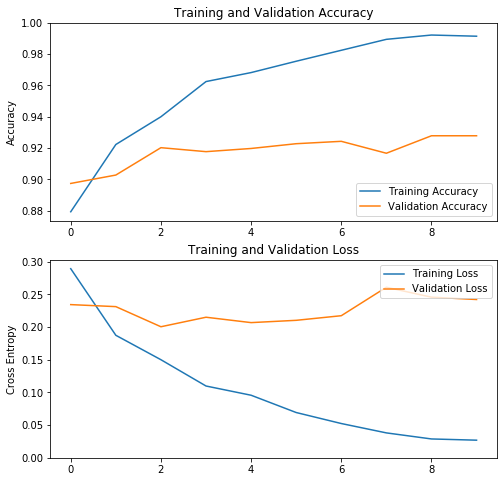

In [21]:
plot_history(history_fine)

-----------------------

### Other Notes

### Using the bottleneck features of a pre-trained network

A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset. This model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. However, the method we present here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

Instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features. [Blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

### Fine-tuning the top layers of a a pre-trained network

To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

- Instantiate the convolutional base of VGG16 and load its weights
- Add our previously defined fully-connected model on top, and load its weights
- Freeze the layers of the VGG16 model up to the last convolutional block

### In order to perform fine-tuning...

- All layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.


- We choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).


- Fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.


### Fine-tune the last 3 convolutional layers

All layers up until block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

- Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

### Approaches to get a better score

- More aggresive data augmentation
- More aggressive dropout
- Use of L1 and L2 regularization (also known as "weight decay")
- Fine-tuning one more convolutional block (alongside greater regularization)